In [2]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical CPU, 1 Logical CPU


In [3]:
# import the required image preprocessing functions 
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions

# import the models for further classification experiments
from tensorflow.keras.applications import (
        vgg16,
        resnet,
        mobilenet,
        inception_v3
    )

import matplotlib.pyplot as plt
import numpy as np

# imports for reproducibility
import tensorflow as tf
import random
import os

%matplotlib inline

In [4]:
# settings for reproducibility
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Load the models from keras applications folder

In [5]:
# init the models
vgg_model = vgg16.VGG16(weights='imagenet')

In [6]:
inception_model = inception_v3.InceptionV3(weights='imagenet')

In [10]:
resnet_model = resnet.ResNet50(weights='imagenet')

In [11]:
mobilenet_model = mobilenet.MobileNet(weights='imagenet')

Let's define the image path for further experiments in the ``filename`` variable. Please note, that there are other images in the ``images`` directory that you can use as well to test the models.

In [12]:
# assign the image path for the classification experiments
filename = 'pretrained-imagenet-models-classification/cat.jpg'

## Perform Pre-processing before feeding the image to the network

#### We perform the following pre-processing to the image

1. Keras loads the image using PIL library. This is done using the **load_img** function. The image is in width x height x channels format.
2. Convert the image from PIL format to Numpy format ( height x width x channels ) using **image_to_array** function.
3. Form a batch of image( s ) to feed the network. This is done using the **expand_dims** function in Numpy

PIL image size (224, 224)


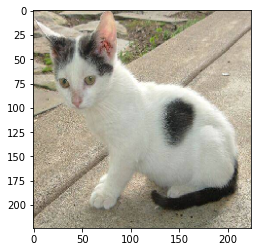

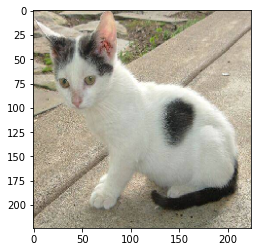

numpy array size (224, 224, 3)
image batch size (1, 224, 224, 3)


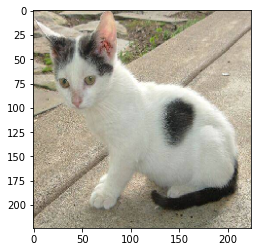

In [13]:
# load an image in PIL format
original = load_img(filename, target_size=(224, 224))
print('PIL image size',original.size)
plt.imshow(original)
plt.show()

# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)
plt.imshow(np.uint8(numpy_image))
plt.show()
print('numpy array size',numpy_image.shape)

# Convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels)
# Thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)
plt.imshow(np.uint8(image_batch[0]))

## Predictions using the various Network

1. Preprocess the input by subtracting the mean value from each channel of the images in the batch. Mean is an array of three elements obtained by the average of R, G, B pixels of all images obtained from ImageNet
2. get the probabilities of occurrence for each class
3. convert the probabilities to human-readable labels

### VGG16 Network

In [14]:
# prepare the image for the VGG model
processed_image = vgg16.preprocess_input(image_batch.copy())

# get the predicted probabilities for each class
predictions = vgg_model.predict(processed_image)
# print predictions
# convert the probabilities to class labels
# we will get top 5 predictions which is the default
label_vgg = decode_predictions(predictions)
# print VGG16 predictions
for prediction_id in range(len(label_vgg[0])):
    print(label_vgg[0][prediction_id])

('n02123597', 'Siamese_cat', 0.31094304)
('n01877812', 'wallaby', 0.07813947)
('n02326432', 'hare', 0.07326389)
('n02325366', 'wood_rabbit', 0.05144352)
('n03223299', 'doormat', 0.049011365)


### ResNet50 Network

In [16]:
# prepare the image for the ResNet50 model
processed_image = resnet.preprocess_input(image_batch.copy())

# get the predicted probabilities for each class
predictions = resnet_model.predict(processed_image)

# convert the probabilities to class labels
# If you want to see the top 3 predictions, specify it using the top argument
label_resnet = decode_predictions(predictions, top=3)
# print ResNet predictions
for prediction_id in range(len(label_resnet[0])):
    print(label_resnet[0][prediction_id])

('n02124075', 'Egyptian_cat', 0.15990637)
('n03958227', 'plastic_bag', 0.1448654)
('n03223299', 'doormat', 0.13230407)


### MobileNet Network

In [17]:
# prepare the image for the MobileNet model
processed_image = mobilenet.preprocess_input(image_batch.copy())

# get the predicted probabilities for each class
predictions = mobilenet_model.predict(processed_image)

# convert the probabilities to imagenet class labels
label_mobilenet = decode_predictions(predictions)
# print MobileNet predictions
for prediction_id in range(len(label_mobilenet[0])):
    print(label_mobilenet[0][prediction_id])

('n03958227', 'plastic_bag', 0.15318264)
('n02124075', 'Egyptian_cat', 0.11321195)
('n02123597', 'Siamese_cat', 0.10798528)
('n02123045', 'tabby', 0.075391985)
('n02909870', 'bucket', 0.05158636)


### Inception_V3 Network

+ The input size for inception network is different from the other networks. It accepts inputs of size (299, 299).
+ Thus we load the image with target size according to that.

In [18]:
# load an image in PIL format
original = load_img(filename, target_size=(299, 299))

# Convert the PIL image into numpy array
numpy_image = img_to_array(original)

# reshape data in terms of batchsize
image_batch = np.expand_dims(numpy_image, axis=0)

# prepare the image for the Inception model
processed_image = inception_v3.preprocess_input(image_batch.copy())

# get the predicted probabilities for each class
predictions = inception_model.predict(processed_image)

# convert the probabilities to class labels
label_inception = decode_predictions(predictions)
# print Inception predictions
for prediction_id in range(len(label_inception[0])):
    print(label_inception[0][prediction_id])

('n02124075', 'Egyptian_cat', 0.6817837)
('n02123045', 'tabby', 0.043200757)
('n02123597', 'Siamese_cat', 0.036385432)
('n02123159', 'tiger_cat', 0.021852255)
('n03223299', 'doormat', 0.013626697)


In [19]:
numpy_image = np.uint8(img_to_array(original)).copy()
numpy_image = cv2.resize(numpy_image,(900,900))

# format final image visualization to display the results of experiments
cv2.putText(numpy_image, "VGG16: {}, {:.2f}".format(label_vgg[0][0][1], label_vgg[0][0][2]) , (350, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
cv2.putText(numpy_image, "MobileNet: {}, {:.2f}".format(label_mobilenet[0][0][1], label_mobilenet[0][0][2]) , (350, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
cv2.putText(numpy_image, "Inception: {}, {:.2f}".format(label_inception[0][0][1], label_inception[0][0][2]) , (350, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
cv2.putText(numpy_image, "ResNet50: {}, {:.2f}".format(label_resnet[0][0][1], label_resnet[0][0][2]) , (350, 145), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
numpy_image = cv2.resize(numpy_image, (700,700))
cv2.imwrite("images/{}_output.jpg".format(filename.split('/')[-1].split('.')[0]),cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR))

False

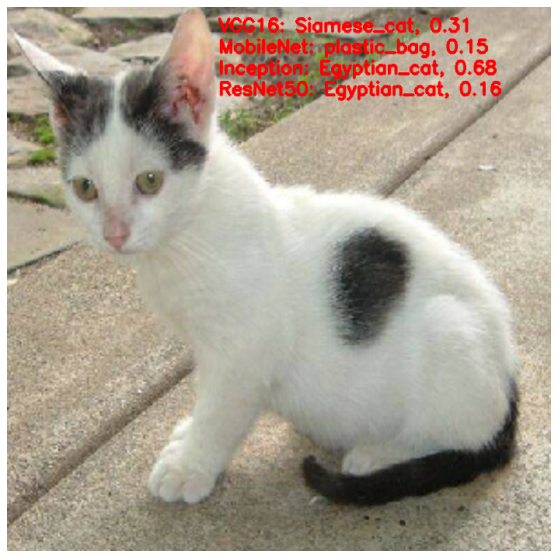

In [20]:
plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(numpy_image)